In [16]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from datetime import date, timedelta  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, linear_model
from sklearn.decomposition import TruncatedSVD
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import unittest
import os



In [61]:
df = pd.read_feather('C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/rts27.feather')

#Columns deemed unneccessary for this task
df.drop(['file_name','designated_market_makers','legal_entity_name', 'systematic_internaliser_flag'], axis = 1, inplace = True)


In [62]:
#Filters the code to FX forwards only
df = df.loc[(df['instrument_classification']).astype(str).str.contains("JF") | (df['source_instrument_desc']).astype(str).str.contains("Forward") | (df['source_instrument_name']).astype(str).str.contains("Forward")]
df = df.drop(['order_request_quotes_received', 'liquidity_provider_flag','executed_transactions', 'median_size_request_quotes_gbp','egb_eligible_flag','data_quality_flag','central_bank_isin_flag', 'data_quality_flag', 'smartie_instrument_name', 'active', 'business', 'order_request_quotes_can_wdrwn','order_request_quotes_modified'], axis = 1)

#df.to_csv('C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/RTS27filtered.csv')
print(df['bank_name'].unique()) 

['Credit Suisse' 'Morgan Stanley' 'Deutsche Bank' 'HSBC' 'Goldman Sachs'
 'BAML' 'Societe Generale' 'Natwest Markets' 'Barclays' 'Nomura'
 'JPMorgan Chase' 'Citibank' 'UBS' 'BNP Paribas']


In [82]:
def concat_tables():
    dfArray = []
    dfArray.append(pd.read_csv('C:/NWM/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20180103_20180331.csv'))
    dfArray.append(pd.read_csv('C:/NWM/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20180401_20180630.csv'))
    dfArray.append(pd.read_csv('C:/NWM/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20180701_20180930.csv'))
    dfArray.append(pd.read_csv('C:/NWM/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20181001_20181231.csv'))
    dfArray.append(pd.read_csv('C:/NWM/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20190101_20190331.csv'))
    newData = pd.concat(dfArray)
    return newData

def modifying_table_data():
    newData = concat_tables()
    newData = newData.rename(columns={'Financial Instrument Name':'source_instrument_name', 'Instrument Identifier(ISO 6166)':'instrument_identifier'})
    newData = newData[['source_instrument_name','instrument_identifier']].dropna()
    newData.drop_duplicates(subset ='instrument_identifier', keep = 'first', inplace = True) 
    df['source_instrument_name'] = df['instrument_identifier'].map(newData.set_index('instrument_identifier')['source_instrument_name'])
    return df

df = modifying_table_data()


In [84]:
df

,id,bank_name,date_of_trading_day,instrument_identifier,instrument_classification,total_value_of_transactions,median_transaction_size,median_size_request_quotes,date_created,source_instrument_desc,...,source_market_segment,smartie_instrument_id,traded_in_natwest_markets,source_instrument_name,total_value_of_trans_eur,total_value_of_trans_gbp,median_transaction_size_eur,median_transaction_size_gbp,median_size_request_quotes_eur,year_quarter
59,73994359,Credit Suisse,2018-10-16,None,None,0.0,NaN,3.289154e+06,2019-05-13 14:24:39,Foreign Exchange Derivatives / Deliverable For...,...,CSSI,None,No,NaN,NaN,NaN,NaN,NaN,NaN,2018 Q4
61,73994361,Credit Suisse,2018-10-16,None,None,0.0,NaN,6.407490e+06,2019-05-13 14:24:39,Foreign Exchange Derivatives / Deliverable For...,...,CSSI,None,No,NaN,NaN,NaN,NaN,NaN,NaN,2018 Q4
72,73994372,Credit Suisse,2018-10-16,None,None,0.0,NaN,1.749228e+04,2019-05-13 14:24:39,Foreign Exchange Derivatives / Deliverable For...,...,CSSI,None,No,NaN,NaN,NaN,NaN,NaN,NaN,2018 Q4
73,73994373,Credit Suisse,2018-10-16,None,None,0.0,NaN,3.354355e+03,2019-05-13 14:24:39,Foreign Exchange Derivatives / Deliverable For...,...,CSSI,None,No,NaN,NaN,NaN,NaN,NaN,NaN,2018 Q4
100,67771594,Morgan Stanley,2018-09-13,EZ43HP8WC2Y3,JFTXFC,NaN,NaN,NaN,2019-01-15 15:01:55,None,...,None,None,Yes,Foreign_Exchange Forward NDF BRL USD 20190702,NaN,NaN,NaN,NaN,NaN,2018 Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12944796,26026212,HSBC,2018-05-07,EZ21BZ1JJDZ1,None,0.0,0.0,0.000000e+00,2019-01-02 10:51:56,Foreign_Exchange Forward EUR USD 20181207,...,None,None,Yes,Foreign_Exchange Forward EUR USD 20181207,NaN,NaN,NaN,NaN,NaN,2018 Q2
12944797,26026214,HSBC,2018-05-07,EZ21D960L7S5,None,0.0,0.0,0.000000e+00,2019-01-02 10:51:56,Foreign_Exchange Forward AUD USD 20180511,...,None,None,Yes,Foreign_Exchange Forward AUD USD 20180511,NaN,NaN,NaN,NaN,NaN,2018 Q2
12944798,26026215,HSBC,2018-05-07,EZ21D9K7QWR9,None,828436.4,24500.0,2.450000e+04,2019-01-02 10:51:56,Foreign_Exchange Forward NDF IDR USD 20180608,...,None,None,Yes,Foreign_Exchange Forward NDF IDR USD 20180608,694356.214902,612522.292052,20534.74143,18114.602588,20534.74143,2018 Q2
12944799,26026216,HSBC,2018-05-07,EZ21GFMFMGW2,None,0.0,0.0,0.000000e+00,2019-01-02 10:51:56,Foreign_Exchange Forward CNY EUR 20190211,...,None,None,No,NaN,NaN,NaN,NaN,NaN,NaN,2018 Q2


In [85]:

df['total_value_of_trans_gbp'] = df['total_value_of_trans_gbp'].fillna(df['total_value_of_trans_eur']).fillna(df['total_value_of_transactions'])
df.head(10)

,id,bank_name,date_of_trading_day,instrument_identifier,instrument_classification,total_value_of_transactions,median_transaction_size,median_size_request_quotes,date_created,source_instrument_desc,...,source_market_segment,smartie_instrument_id,traded_in_natwest_markets,source_instrument_name,total_value_of_trans_eur,total_value_of_trans_gbp,median_transaction_size_eur,median_transaction_size_gbp,median_size_request_quotes_eur,year_quarter
59,73994359,Credit Suisse,2018-10-16,None,None,0.0,NaN,3.289154e+06,2019-05-13 14:24:39,Foreign Exchange Derivatives / Deliverable For...,...,CSSI,None,No,NaN,NaN,0.0,NaN,NaN,NaN,2018 Q4
61,73994361,Credit Suisse,2018-10-16,None,None,0.0,NaN,6.407490e+06,2019-05-13 14:24:39,Foreign Exchange Derivatives / Deliverable For...,...,CSSI,None,No,NaN,NaN,0.0,NaN,NaN,NaN,2018 Q4
72,73994372,Credit Suisse,2018-10-16,None,None,0.0,NaN,1.749228e+04,2019-05-13 14:24:39,Foreign Exchange Derivatives / Deliverable For...,...,CSSI,None,No,NaN,NaN,0.0,NaN,NaN,NaN,2018 Q4
73,73994373,Credit Suisse,2018-10-16,None,None,0.0,NaN,3.354355e+03,2019-05-13 14:24:39,Foreign Exchange Derivatives / Deliverable For...,...,CSSI,None,No,NaN,NaN,0.0,NaN,NaN,NaN,2018 Q4
100,67771594,Morgan Stanley,2018-09-13,EZ43HP8WC2Y3,JFTXFC,NaN,NaN,NaN,2019-01-15 15:01:55,None,...,None,None,Yes,Foreign_Exchange Forward NDF BRL USD 20190702,NaN,NaN,NaN,NaN,NaN,2018 Q3
101,67771595,Morgan Stanley,2018-09-28,EZ24NVRGSWM1,JFTXFP,NaN,NaN,NaN,2019-01-15 15:01:55,None,...,None,None,Yes,Foreign_Exchange Forward SEK USD 20181004,NaN,NaN,NaN,NaN,NaN,2018 Q3
102,67771596,Morgan Stanley,2018-09-06,None,JFTXFP,NaN,NaN,NaN,2019-01-15 15:01:55,USDTRY 1 MONE MONE PHYS,...,None,None,No,NaN,NaN,NaN,NaN,NaN,NaN,2018 Q3
103,67771597,Morgan Stanley,2018-07-13,EZ6HV8SZ0GB1,JFTXFP,NaN,NaN,NaN,2019-01-15 15:01:55,None,...,None,None,Yes,Foreign_Exchange Forward TRY USD 20200717,NaN,NaN,NaN,NaN,NaN,2018 Q3
104,67771598,Morgan Stanley,2018-08-31,None,JFTXFP,NaN,NaN,NaN,2019-01-15 15:01:55,USDDKK 1 MONE MONE PHYS,...,None,None,No,NaN,NaN,NaN,NaN,NaN,NaN,2018 Q3
105,67771599,Morgan Stanley,2018-07-20,EZW2B7BGWGS3,JFTXFP,NaN,NaN,NaN,2019-01-15 15:01:55,None,...,None,None,Yes,Foreign_Exchange Forward EUR SEK 20180725,NaN,NaN,NaN,NaN,NaN,2018 Q3


In [86]:
df.to_csv('C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/RTS27filtered.csv')

In [87]:
reducedRTS = pd.read_csv("C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/RTS27filtered.csv")

C:\Users\inald\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


['HSBC' 'Deutsche Bank' 'Goldman Sachs' 'BAML' 'Morgan Stanley'
 'Natwest Markets' 'Societe Generale' 'Barclays' 'JPMorgan Chase' 'Nomura'
 'Citibank' 'UBS']


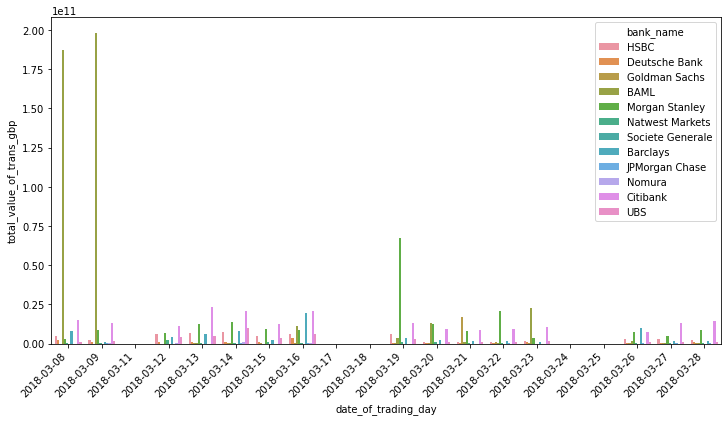

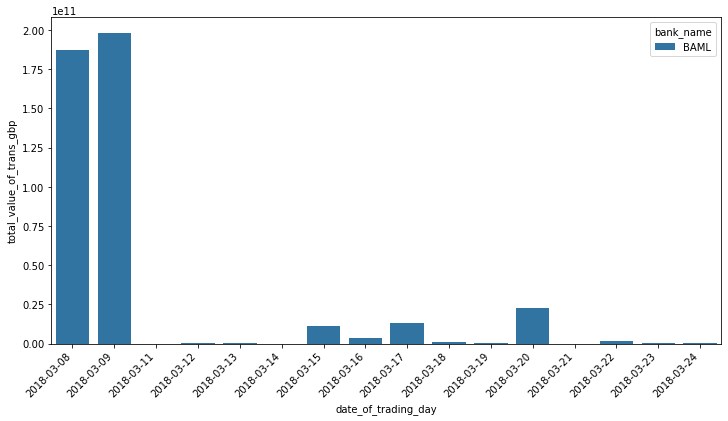

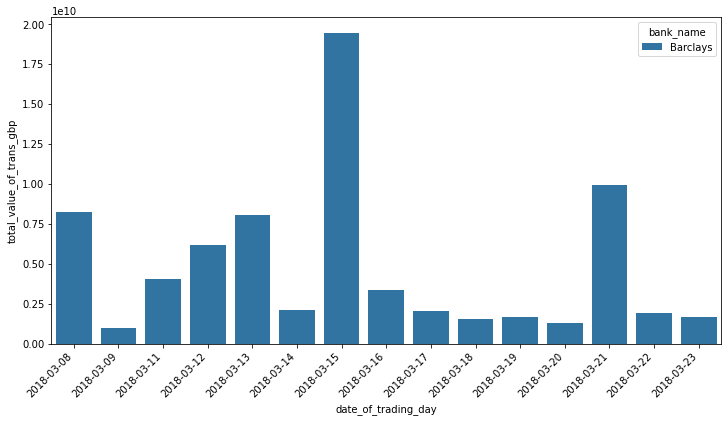

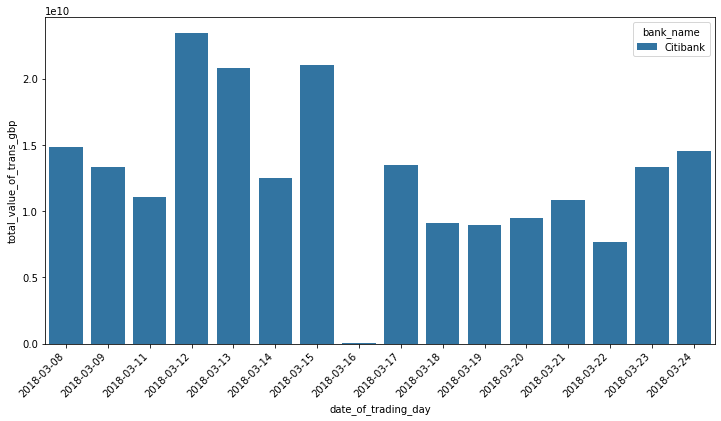

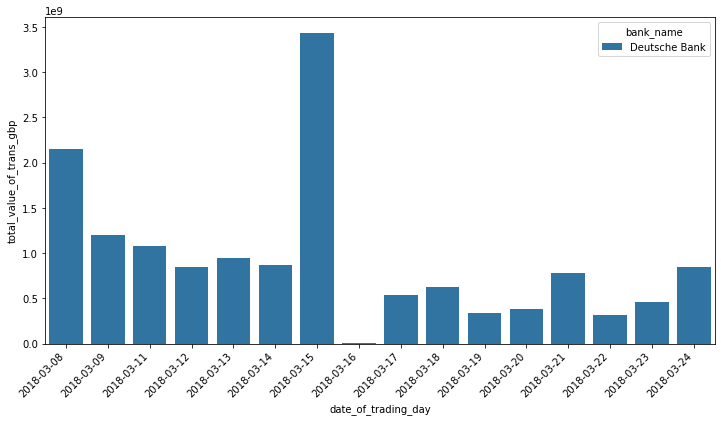

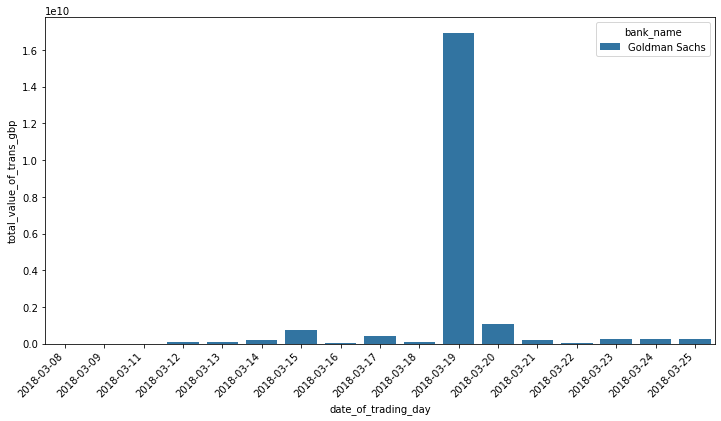

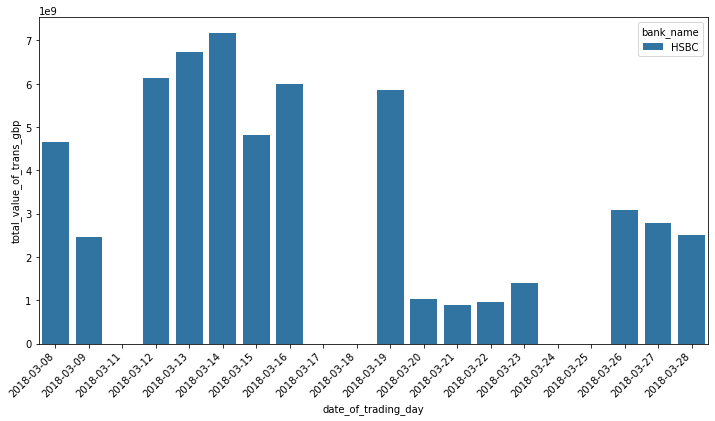

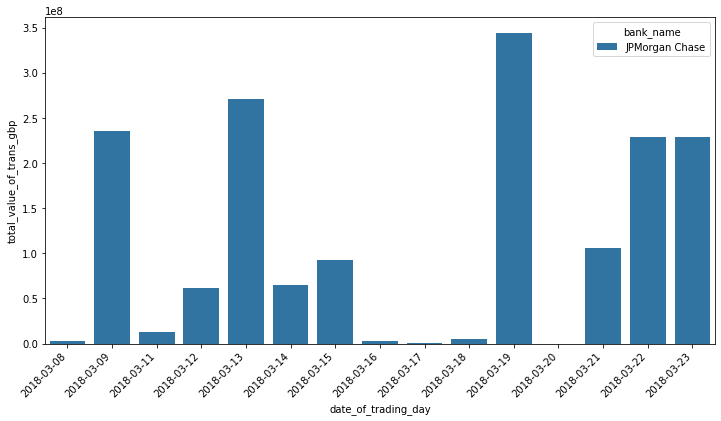

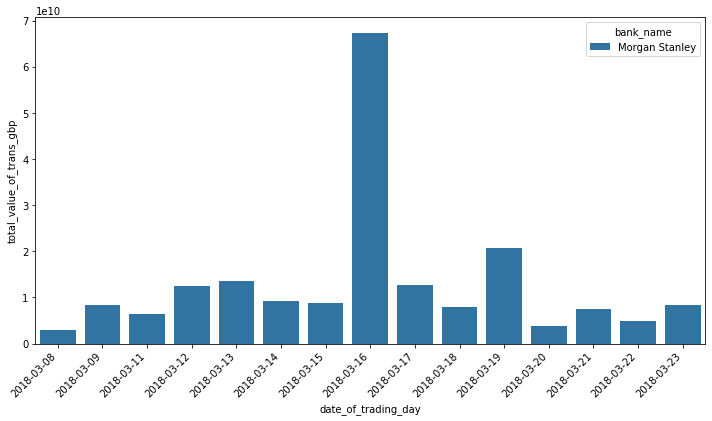

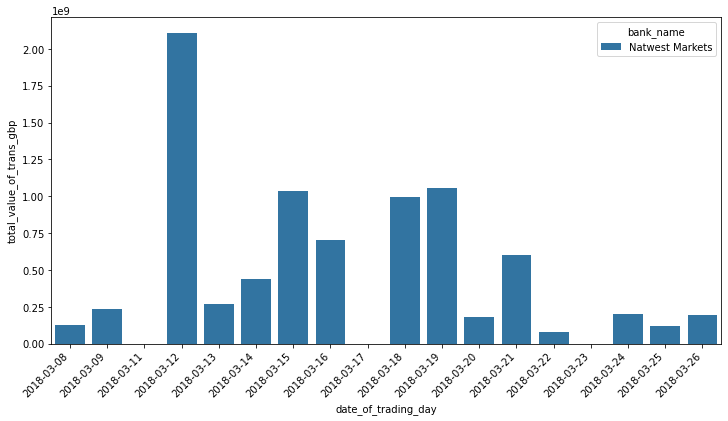

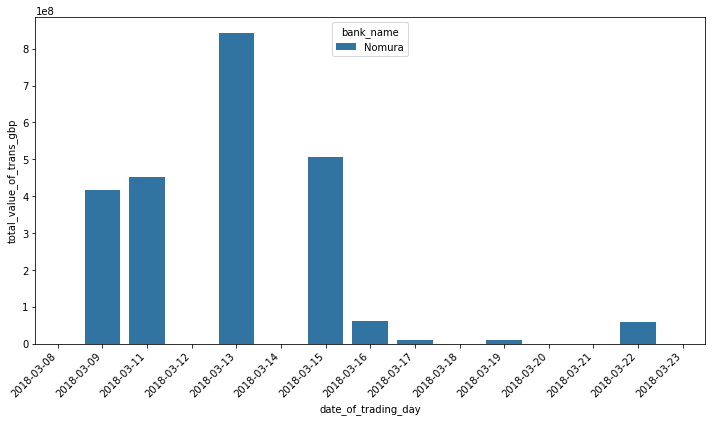

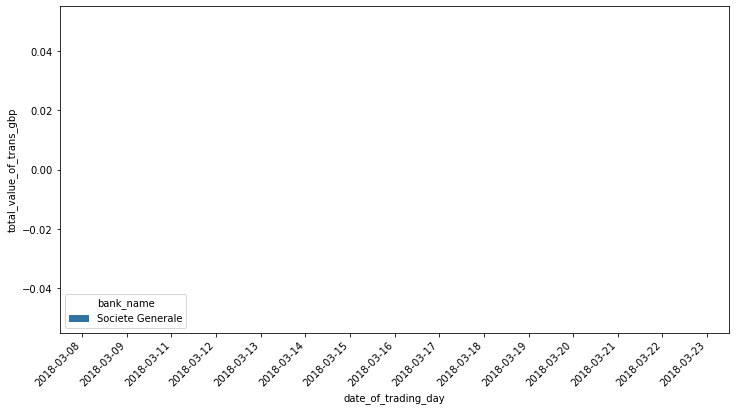

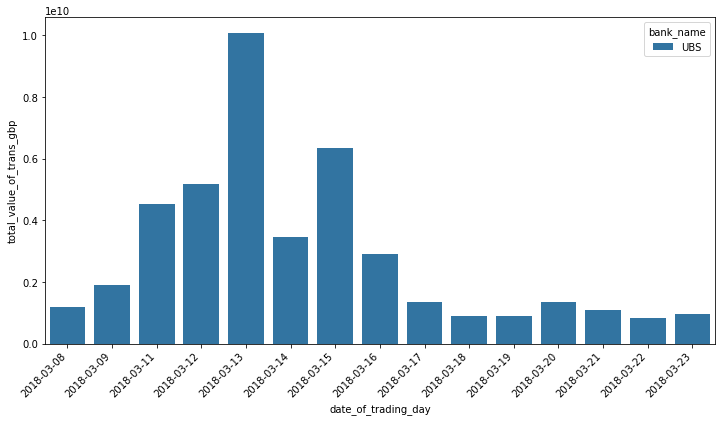

In [92]:
reducedRTS['date_of_trading_day'] = pd.to_datetime(reducedRTS['date_of_trading_day'])

def get_quarter(start_date, end_date, data, imm_date):
    mask = (reducedRTS['date_of_trading_day'] > start_date) & (reducedRTS['date_of_trading_day'] <= end_date) & ((reducedRTS['source_instrument_desc']).astype(str).str.contains(imm_date) | (reducedRTS['source_instrument_name']).astype(str).str.contains(imm_date))
    rtsQ = reducedRTS.loc[mask]
    return rtsQ

#df = df.loc[mask]
q1Rts = get_quarter('2018-03-07', '2018-03-28', reducedRTS, "20180620")
#q2Rts = get_quarter('2018-06-06', '2018-06-27', reducedRTS, "20180919")
#q3Rts = get_quarter('2018-09-05', '2018-09-26', reducedRTS, "20181219")
#q4Rts = get_quarter('2018-12-05', '2018-12-26', reducedRTS, "20190320")

fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(x = q1Rts['date_of_trading_day'], y = q1Rts['total_value_of_trans_gbp'], estimator = sum, ci = None ,ax=ax, hue = q1Rts['bank_name'])
x_dates = q1Rts['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
print(q1Rts['bank_name'].unique())

banks = q1Rts.groupby(reducedRTS['bank_name'])
for i, bank in banks:
    fig, ax = plt.subplots(figsize = (12,6))
    sns.barplot(x = bank['date_of_trading_day'], y = bank['total_value_of_trans_gbp'], estimator = sum, ci = None ,ax=ax, hue = bank['bank_name'])
    x_dates = q1Rts['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

plt.show()

In [ ]:
# Select target
y = df['total_value_of_transactions']
# To keep things simple, we'll use only numerical predictors
dropped_df = df.drop(['total_value_of_transactions'], axis=1)
X = dropped_df

im = SimpleImputer(strategy='mean',missing_values=np.nan)
y = y.to_numpy().reshape(-1,1)
y = im.fit_transform(y)
y = pd.DataFrame(y)
print(y)

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

categorical_cols = [col for col in X.columns if X[col].dtype in ['object']]

# Select numerical columns
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
       
# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()

numerical_transformer = SimpleImputer(strategy='mean',missing_values=np.nan)

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',missing_values=None, fill_value='missing_value')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

sc = StandardScaler()

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough')

model = linear_model.LinearRegression()

#print(preprocessor.fit_transform(X_train, y_train))

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('scaler', sc),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)


# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)
svd = TruncatedSVD(n_components=5)
svd.fit_transform(X_train, y_train, mean=False)
svd.transform(preds, mean=False)
print(X_train.head(10))

print('Coefficients: \n', model.coef_)

In [ ]:
fig, ax = plt.subplots(figsize = (12,6)) 
#sns.barplot(x = df['date_of_trading_day'], y = df['total_value_of_trans_eur'], estimator = sum, ci = None, ax=ax, hue = df['bank_name'])

sns.countplot(x = df['date_of_trading_day'], ax=ax, hue = df['bank_name'])

x_dates = df['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

#new graph - showing off the total value of gbp traded
volume = df.groupby('total_value_of_trans_gbp')
fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(x = df['date_of_trading_day'], y = df['total_value_of_trans_gbp'], estimator = sum, ci = None ,ax=ax, hue = df['bank_name'])
x_dates = df['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

sns.pairplot(reducedRTS, hue = 'bank_name')
plt.show()

In [ ]:
TESTDATA_FILENAME = 'C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/rts27.feather'
dfTest = pd.read_feather('C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/rts27.feather')

In [ ]:
class TestNotebook(unittest.TestCase):
    
    
    def test_add(self):
        self.assertEqual(4,4)

    #checks that the dataframes contain frames
    def test_data_read(self):
        if dfTest.empty:
            self.assertTrue(False)
        else:
            self.assertTrue(True)
    
    #Test to check that columns are disposed of that are not needed        
    def test_dropping_columns(self):
        dropped_df = dfTest.drop(['date_created', 'instrument_identifier'], axis=1)
        Xtest = dropped_df
        count = 0
        count2 = 0
        for col in dfTest.columns:
            count = count + 1
        for col in Xtest.columns:
            count2 = count + 1
        self.assertNotEqual(count, count2)
        
   #Test to check that the train data is larger than the test - test the 80% v 20% difference    
    def test_splitting_data_size(self):
        Xtest = dfTest.drop(['date_created', 'instrument_identifier'], axis=1)
        ytest = dfTest['date_created']
        Xtest_train, Xtest_valid, ytest_train, ytest_valid = train_test_split(Xtest, ytest, train_size=0.8, test_size=0.2, random_state=0)
        if Xtest_train.size > Xtest_valid.size:
            self.assertTrue(True)
        else:
            self.assertTrue(False)
    
    unittest.main(argv=[''], verbosity=3, exit=False)
   